In [ ]:
class config:
    
    # Test data specifications
    DataFile = r'weather/testdata.csv'
    DateCol = 0
    PowerCol = 1
    TempCol = 2
    DateName = "datetime"
    PowerName = "power"
    TempName = "temperature"
    
    # Optimizer settings
    MaxIterations = 100
    Theat = 40.0 # initial heating balance temperature
    Tcool = 90.0 # initial cooling balance temperature
    MaxSlope = 0.1 # maximum slope to allow for base load
    Epsilon = 0.1 # temperature resolution
    Alpha = 50.0 # weight of base slope value in score
    Beta = 100.0 # weight of heating rvalue
    Gamma = 100.0 # weight of cooling rvalue


In [ ]:
import weather.sensitivity as lm
data = lm.load_data(ifile=config.DataFile,datetime_col=config.DateCol,power_col=config.PowerCol,temperature_col=config.TempCol)
hour = list(map(lambda h: lm.get_hours(data,[h]),range(24)))

----

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pwlf

def partition_data(data,Theat,Tcool):
    T = data['temperature']
    heat = data[T<Theat]
    base = data[(T>=Theat) & (T<Tcool)]
    cool = data[T>=Tcool]
    return heat,base,cool
    
def find_balance_temperatures(x,y):

    model = pwlf.PiecewiseLinFit(x, y)

    pt2 = model.fit(2)
    yp2 = model.predict(x)
    er2 = pow(yp2-y,2).sum()

    pt3 = model.fit(3)
    yp3 = model.predict(x)
    er3 = pow(yp3-y,2).sum()

    Tdiff = pt3[2]-pt3[1]
    Tbase = pt2[1]

    Theat = Tbase - Tdiff/2
    Tcool = Tbase + Tdiff/2
    
    return (Theat, Tcool)

def linear_model(x,y,constraint={}):
    if type(constraint) is dict:
        if len(constraint.keys()) == 0:
            S,I,R,V,E = st.linregress(x,y)
            return S,I,R,V,E
        elif len(constraint.keys()) > 1:
            raise Exception("only one constraint is allowed at a time")
        if "slope" in constraint.keys():
            return y.mean()
        if "intercept" in constraint.keys():
            return None
    else:
        raise Exception("constaint must be None or dict")

Pheat[0] = -31.7 T + 1771.1, Pcool0 = 41.3 T + 1771.1
Pheat[1] = -34.4 T + 1693.5, Pcool1 = 32.0 T + 1693.5
Pheat[2] = -36.0 T + 1650.6, Pcool2 = 26.0 T + 1650.6
Pheat[3] = -38.3 T + 1645.7, Pcool3 = 21.6 T + 1645.7
Pheat[4] = -40.0 T + 1685.3, Pcool4 = 18.5 T + 1685.3
Pheat[5] = -41.0 T + 1808.3, Pcool5 = 14.0 T + 1808.3
Pheat[6] = -43.0 T + 2020.4, Pcool6 = 6.8 T + 2020.4
Pheat[7] = -40.5 T + 2162.5, Pcool7 = 12.4 T + 2162.5
Pheat[8] = -39.1 T + 2246.1, Pcool8 = 17.3 T + 2246.1
Pheat[9] = -39.1 T + 2311.8, Pcool9 = 21.7 T + 2311.8
Pheat[10] = -36.8 T + 2342.7, Pcool10 = 28.3 T + 2342.7
Pheat[11] = -34.7 T + 2354.8, Pcool11 = 33.1 T + 2354.8
Pheat[12] = -32.4 T + 2362.8, Pcool12 = 42.0 T + 2362.8
Pheat[13] = -30.4 T + 2355.7, Pcool13 = 46.4 T + 2355.7
Pheat[14] = -28.4 T + 2331.6, Pcool14 = 50.1 T + 2331.6
Pheat[15] = -27.3 T + 2321.4, Pcool15 = 54.3 T + 2321.4
Pheat[16] = -29.5 T + 2329.9, Pcool16 = 57.1 T + 2329.9
Pheat[17] = -35.1 T + 2352.6, Pcool17 = 55.6 T + 2352.6
Pheat[18] = -

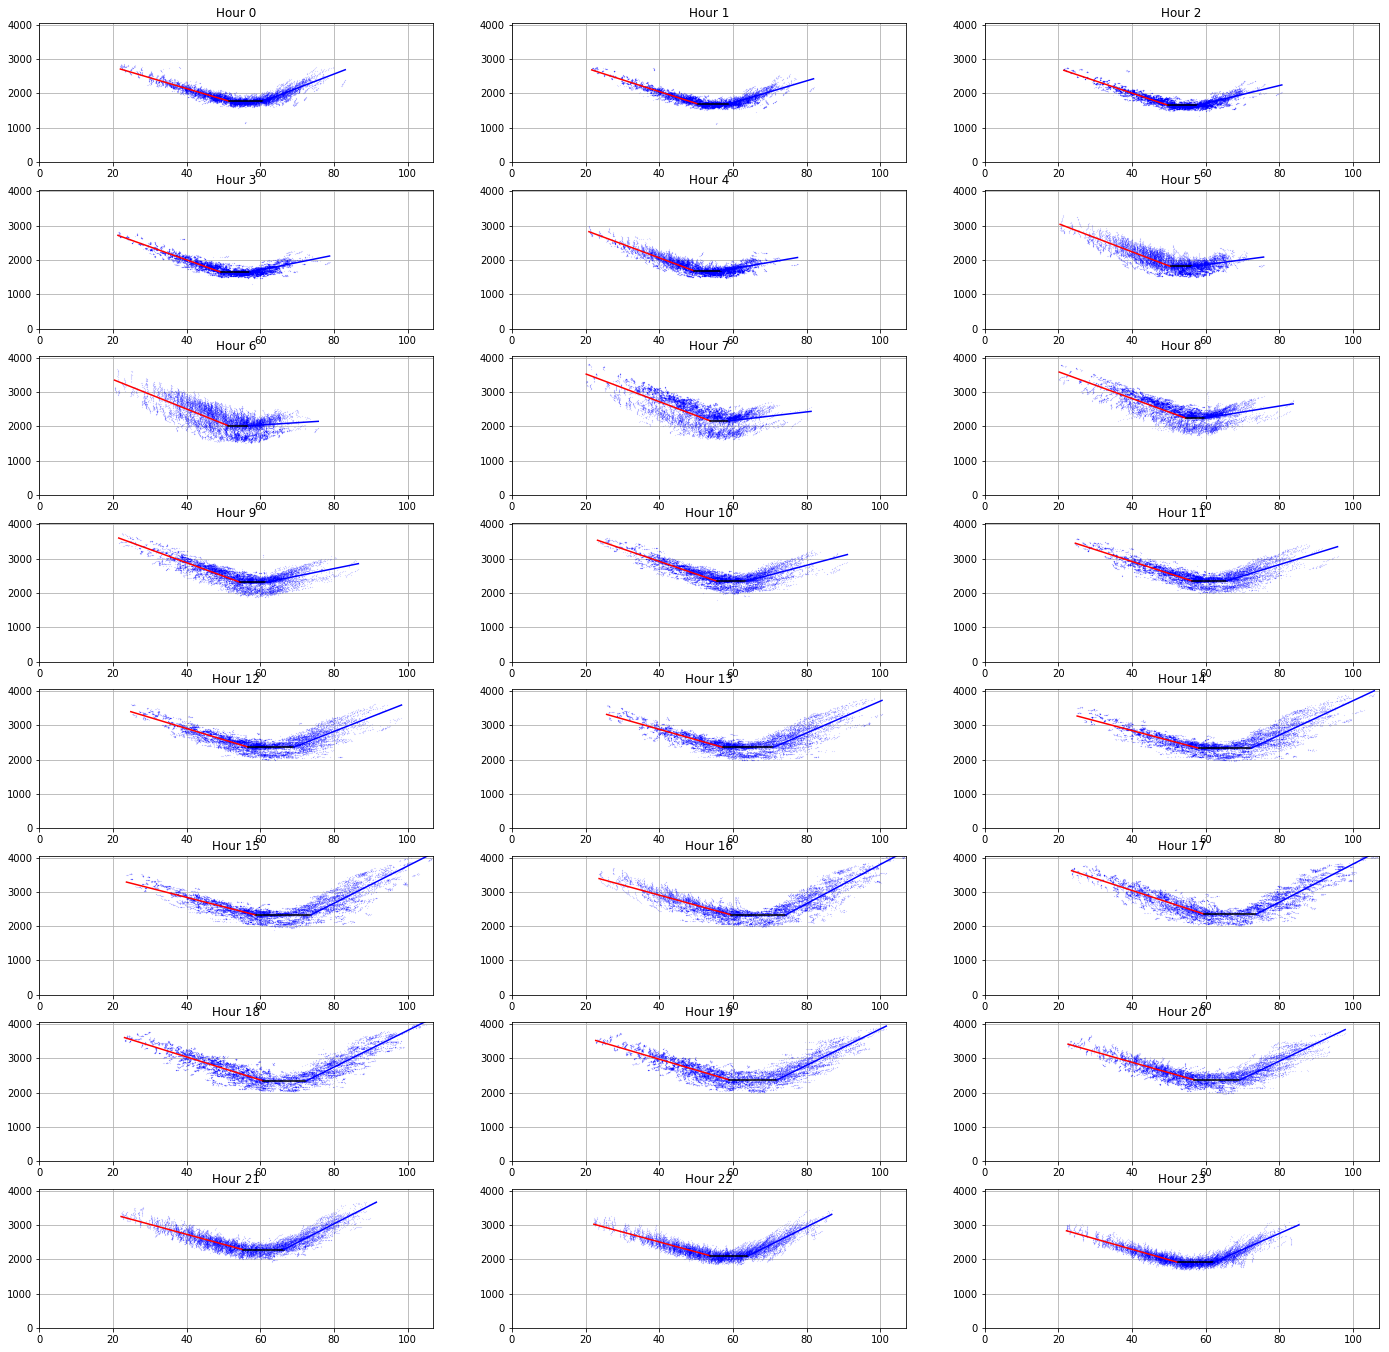

In [10]:
Theat = []
Tcool = []
Pbase = []
Sheat = []
Scool = []

fig = plt.figure(figsize=(24,24))
ax = fig.subplots(8,3).flatten()
xmax = data["temperature"].max()
ymax = data["power"].max()

for h in range(24):
    
    T = hour[h]["temperature"]
    Tmin = T.min()
    Tmax = T.max()
    
    P = np.array(hour[h]["power"])
    
    Tbal = find_balance_temperatures(T,P)
    Theat.append(round(Tbal[0],1))
    Tcool.append(round(Tbal[1],1))
    
    A = np.zeros((len(T),3))
    b = np.array(P)
    heating, = np.where(T<Tbal[0])
    cooling, = np.where(T>=Tbal[1])
    A[:,0] = 1.0
    A[heating,1] = T[heating] - Tbal[0]
    A[cooling,2] = T[cooling] - Tbal[1]
    
    At = A.transpose()
    AtA = np.matmul(At,A)
    AtY = np.matmul(At,P)
    x = np.linalg.solve(AtA,AtY)
    Pbase.append(x[0])
    Sheat.append(x[1])
    Scool.append(x[2])

    def model(T,S,I):
        return np.array(T)*S+I

    print(f"Pheat[{h}] = {x[1]:.1f} T + {x[0]:.1f}, Pcool{h} = {x[2]:.1f} T + {x[0]:.1f}")

    Pmin = model(Tmin-Tbal[0],x[1],x[0])
    Pmax = model(Tmax-Tbal[1],x[2],x[0])
    
    ax[h].plot(T,P,'.',ms=0.1,color='blue')
    ax[h].plot([Tmin,Tbal[0]],[Pmin,x[0]],color='red')
    ax[h].plot([Tbal[0],Tbal[1]],[x[0],x[0]],color='black')
    ax[h].plot([Tbal[1],Tmax],[x[0],Pmax],color='blue')
    ax[h].set_xlim([0,xmax])
    ax[h].set_ylim([0,ymax])
    ax[h].set_title(f"Hour {h}")
    ax[h].grid()
    
fig.show()

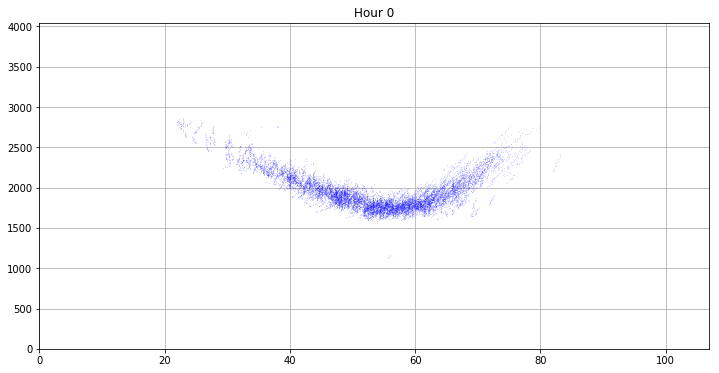

In [17]:
from matplotlib.animation import FuncAnimation
fig = plt.figure(figsize=(12,6))
ax = fig.subplots()
scatter, = ax.plot(hour[h]['temperature'],hour[h]['power'],'.',color='blue',ms=0.1)
ax.set_xlim([0,xmax])
ax.set_ylim([0,ymax])
ax.grid()

def update(h):
    scatter.set_xdata(hour[h]['temperature'])
    scatter.set_ydata(hour[h]['power'])
    ax.set_title(f'Hour {h}')
    return scatter, ax

anim = FuncAnimation(fig,update,frames=np.arange(0,24),interval=60)
anim.save('profiles.gif',dpi=80,writer='pillow')
plt.show()

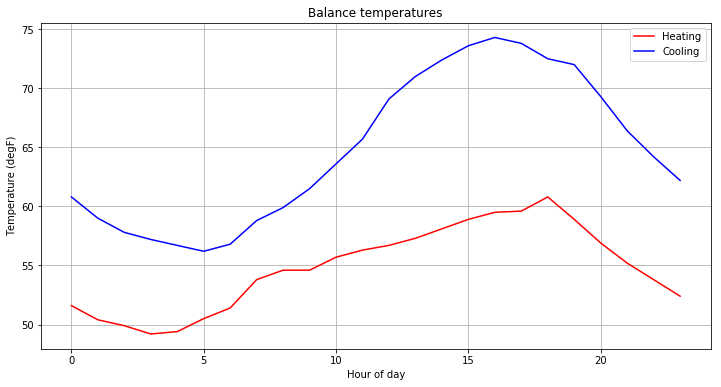

In [15]:
plt.figure(figsize=(12,6))
plt.plot(list(range(24)),Theat,color='red',label='Heating')
plt.plot(list(range(24)),Tcool,color='blue',label='Cooling')
plt.xlabel('Hour of day')
plt.ylabel('Temperature (degF)')
plt.grid()
plt.title('Balance temperatures')
plt.legend()
plt.savefig('balance.png')
plt.show()

----

----